This notebook shows a simulation of a Leaky Integrate and Fire network, made of two layers, an input layer and a hidden layer, no learning or weight adaptation is done so far. <br/>

The input layer shows the dynamics of a LIF neuron, to which a time dependent external current is applied. The values of the current are generated randomly for each time step. <br/>

The hidden layer neurons have the same fundamental behaviour of a LIF neuron, but they aren't affected by external currents and they have no refractory period, while the input neurons have varying refractory periods assigned.<br/>

The two layers are then connected through synapses, the layers are fully connected in this simulation.

In [23]:
from brian2 import *
%matplotlib inline

start_scope()

v_rest = 0*mV
v_thr = 10*mV
tau_m = 10*ms
In_cur = TimedArray((10 + 5*randn(2000))*mV,dt=0.1*ms)

Define the set of equations that describe the behaviour of input neurons. They have the dynamics of LIF neurons but get a time varying input current applied to them. Additionally, the refractory period of the neurons is defined as a state variable of the behaviour so that it can be varied for each neuron in the input layer.

In [24]:
eqs_input = '''
dv/dt = -(v-v_rest-I)/tau_m : volt (unless refractory)
I = In_cur(t) : volt
ref : second
'''

In [25]:
In = NeuronGroup(2, model=eqs_input, threshold='v>v_thr',reset='v=v_rest', refractory='ref')
In.v = [5*mV, 2*mV]
In.ref = [4*ms, 0*ms]

Define the equations that model the behaviour of hidden layer neurons, for simplicity they have no refractory period specified.

In [26]:
eqs_hidd = '''
dv/dt = -(v-v_rest-I)/tau_m : volt (unless refractory)
I : volt
'''

In [27]:
Hidd = NeuronGroup(2, model=eqs_hidd, threshold='v>v_thr', reset='v=v_rest', refractory=0*ms)
Hidd.v = [0*mV]
Hidd.I = [0*mV]

Define the equations that show the dynamics of the synapses connecting the input and hidden layers. For now each synapse just has a weight associated.

In [28]:
synapse_eq = '''
w:1
''' 

In [29]:
S = Synapses(In, Hidd, synapse_eq, on_pre='v_post+=v_pre*w')
S.connect()
S.w = [50, 10 , 1, 1]

Initialise the weights. The equation for synapses would be where we define how and when the connection strengths between neurons are changed based on spikes that occur in the network. <br/>
__S.connect()__ with no further specification of how the connections should be made will connect all neurons fron the source domain __In__ to every neuron from the target domain __Hidd__.<br/>
Then we can just specify values for the weights created. To be noted that the order in which the weights are stored in the array is: __i0-h0, i0-h1, i1-h0, i1-h1__.<br/>
__on_pre__ can also take a set of equations to describe what happens when a presynaptic spike occurs.

INFO       No numerical integration method specified for group 'neurongroup_3', using method 'linear' (took 0.03s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'neurongroup_4', using method 'linear' (took 0.03s). [brian2.stateupdaters.base.method_choice]


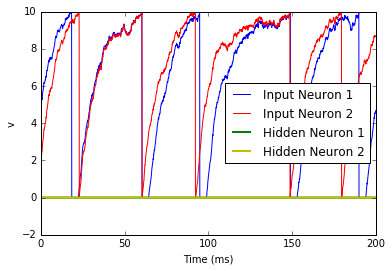

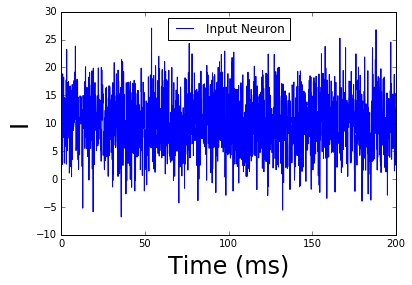

In [30]:
trace_In = StateMonitor(In, ['v','I'], record=True)
trace_Hidd = StateMonitor(Hidd, 'v', record=True)

run(200*ms)

figure(1)
plot(trace_In.t/ms, trace_In.v[0]/mV, '-b', label='Input Neuron 1')
plot(trace_In.t/ms, trace_In.v[1]/mV, '-r', label='Input Neuron 2')
plot(trace_Hidd.t/ms, trace_Hidd.v[0]/mV, '-g', lw=2, label='Hidden Neuron 1')
plot(trace_Hidd.t/ms, trace_Hidd.v[1]/mV, '-y', lw=2, label='Hidden Neuron 2')
xlabel('Time (ms)')
ylabel('v')
legend(loc='best')

figure(2)
plot(trace_In.t/ms, trace_In.I[0]/mV, '-b', label='Input Neuron')
xlabel('Time (ms)', fontsize=24)
ylabel('I', fontsize=24)
legend(loc='best')

show()

In [31]:
start_scope()

v_rest = 0*mV
v_thr = 10*mV
tau_m = 10*ms
In_cur = TimedArray((10 + 5*randn(2000))*mV,dt=0.1*ms)
Neurons_no = 5
Hidd_no = 4

eqs_neurons = '''
dv/dt = -(v - v_rest - I) / tau_m : volt
I = In_cur(t) : volt
ref : second
'''

Redefine the parameters, for a new simulation, using the __start_scope__ function to make sure no prior objects or definitions are used.<br/>
For this simulation we create a network with two layers, the input layer has 5 neurons defined, that are assigned values/spike times based on a Poisson distribution in order to mor realistically simulate the behaviour of a real network.<br/>
The hidden layer has 4 neurons that follow the dynamics of LIF neurons as shown by the equations __eqs_neurons__, they are also applied an input current of varying intensity, that was generated using the __TimedArray__ function as before. 

In [32]:
inputN = PoissonGroup(Neurons_no, rates=15*Hz)
 
neurons_hidd = NeuronGroup(Hidd_no, eqs_neurons, threshold='v>v_thr', reset='v=v_rest', refractory='ref')
neurons_hidd.v = 'rand()*(i+1)*10*mV'
neurons_hidd.ref = 'rand()*(i+1)*10*ms'

The __PoissonGroup__ function creates an array of spikes, generated according to a Poisson distribution, based on a number of neurons and a string expression that is evaluated to a rate.<br/>
The hidden neurons have a varying refractory period, as suggested by the last line in __eqs_neurons__. We then assign a random initial value for the voltage potentials of the neurons in the hidden layer and their refractory periods, by using a string expression that will be reevaluated for each neuron in the __neurons_hidd__ object.

In [33]:
print neurons_hidd.v
print neurons_hidd.ref

<neurongroup.v: array([  1.01484394,  14.74430285,  26.53586604,   0.24888161]) * mvolt>
<neurongroup.ref: array([  0.03763051,   6.2294559 ,  16.93045011,  33.22706101]) * msecond>


We print the randomly generated initial values for the hidden layer parameters, to ensure that they are in a realistic interval.

In [34]:
eqs_synapses = '''
w : 1
'''

S = Synapses(inputN, neurons_hidd, eqs_synapses, on_pre='v_post+=v_thr+w*mV')
S.connect()
S.w = 'rand()%2 * 10'

We define the behaviour of the synapses used to connect the two layers using __eqs_synapses__ and we create a __Synapses__ object to store this behaviour. Once a post-synaptic potential is received by a neuron, the voltage of the neuron, __v_post__ is increased with __w+v_thr__, this is a temporary, heuristic, formula chosen, that will be replaced with a more realistical one in future simulations. <br/>
We connect every neuron in the input layer with every neuron in the hidden layer and we randomly initialise the values of the weigths, for now. 

In [35]:
print S.w

<synapses_1.w: array([ 4.34025909,  8.21655344,  8.50199048,  7.13072786,  2.09364025,
        1.72820614,  6.67665047,  0.27200335,  3.63595894,  4.28089079,
        0.65614063,  4.72386036,  6.79970167,  0.1156953 ,  7.52964613,
        4.69525542,  0.06213628,  4.6388046 ,  5.63479846,  1.58539136])>


In [36]:
hidd_trace = StateMonitor(neurons_hidd, 'v', record=True)
 
weights_trace = StateMonitor(S, 'w', record=True)
spike_trace = SpikeMonitor(inputN)

Define some monitor objects that will track the values of the hidden layer voltages, the weights values and the spike times as recorded during the simulation of the network.<br/>
Following, we display the voltage values of the hidden layer neurons during the simulation.

INFO       No numerical integration method specified for group 'neurongroup', using method 'linear' (took 0.02s). [brian2.stateupdaters.base.method_choice]


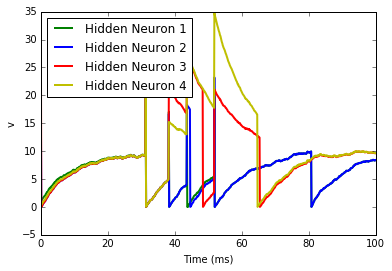

In [37]:
run(100*ms)
 
figure(1)
plot(hidd_trace.t/ms, hidd_trace.v[0]/mV, '-g', lw=2, label='Hidden Neuron 1')
plot(hidd_trace.t/ms, hidd_trace.v[1]/mV, '-b', lw=2, label='Hidden Neuron 2')
plot(hidd_trace.t/ms, hidd_trace.v[2]/mV, '-r', lw=2, label='Hidden Neuron 3')
plot(hidd_trace.t/ms, hidd_trace.v[3]/mV, '-y', lw=2, label='Hidden Neuron 4')
xlabel('Time (ms)')
ylabel('v')
legend(loc='best')

show()